In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score

In [4]:
data = pd.read_csv("C:/Users/athar/jupyter/DSBDA/Google_Stock_Price_Train.csv",thousands=',')
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,623400
1254,12/27/2016,790.68,797.86,787.66,791.55,789100
1255,12/28/2016,793.70,794.23,783.20,785.05,1153800
1256,12/29/2016,783.33,785.93,778.92,782.79,744300


In [31]:
scaler = MinMaxScaler()
data_without_date = data.drop("Date", axis=1)
scaled_data = pd.DataFrame(scaler.fit_transform(data_without_date))

In [33]:
scaled_data = scaled_data.drop([0, 2, 3], axis=1)
scaled_data

,1,4
0,0.096401,0.295258
1,0.098344,0.229936
2,0.092517,0.263612
3,0.088819,0.216179
4,0.076718,0.467797
...,...,...
1253,0.955292,0.024650
1254,0.964853,0.031286
1255,0.958074,0.045891
1256,0.942574,0.029491


In [35]:
def split_seq_multivariate(sequence, n_past, n_future):

    '''
    n_past ==> no of past observations
    n_future ==> no of future observations
    '''
    x = []
    y = []
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(sequence):
            break
        # slicing the past and future parts of the window (this indexing is for 2 features vala data only)
        past = sequence[window_start:past_end, :]
        future = sequence[past_end:future_end, -1]
        x.append(past)
        y.append(future)

    return np.array(x), np.array(y)

In [37]:
n_steps = 60

scaled_data = scaled_data.to_numpy()
scaled_data.shape

(1258, 2)

In [39]:
x, y = split_seq_multivariate(scaled_data, n_steps, 1)

In [41]:
x.shape, y.shape

((1198, 60, 2), (1198, 1))

In [43]:
y = y[:, 0]
y.shape

(1198,)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((958, 60, 2), (240, 60, 2), (958,), (240,))

In [47]:
model = Sequential()
model.add(LSTM(612, input_shape=(n_steps, 2)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))

C:\Users\athar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 612)                 │       1,505,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          30,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,540,281 (5.88 MB)

 Trainable params: 1,540,281 (5.88 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [51]:
history = model.fit(x_train, y_train, epochs=250, batch_size=32, verbose=2, validation_data=(x_test, y_test))

Epoch 1/20
30/30 - 6s - 196ms/step - loss: 0.0084 - mae: 0.0591 - val_loss: 0.0064 - val_mae: 0.0473
Epoch 2/20
30/30 - 4s - 130ms/step - loss: 0.0046 - mae: 0.0401 - val_loss: 0.0057 - val_mae: 0.0412
Epoch 3/20
30/30 - 4s - 133ms/step - loss: 0.0044 - mae: 0.0377 - val_loss: 0.0052 - val_mae: 0.0419
Epoch 4/20
30/30 - 4s - 136ms/step - loss: 0.0044 - mae: 0.0370 - val_loss: 0.0050 - val_mae: 0.0460
Epoch 5/20
30/30 - 4s - 144ms/step - loss: 0.0042 - mae: 0.0363 - val_loss: 0.0048 - val_mae: 0.0383
Epoch 6/20
30/30 - 4s - 136ms/step - loss: 0.0041 - mae: 0.0357 - val_loss: 0.0046 - val_mae: 0.0383
Epoch 7/20
30/30 - 4s - 144ms/step - loss: 0.0039 - mae: 0.0343 - val_loss: 0.0048 - val_mae: 0.0381
Epoch 8/20
30/30 - 4s - 134ms/step - loss: 0.0039 - mae: 0.0338 - val_loss: 0.0044 - val_mae: 0.0388
Epoch 9/20
30/30 - 4s - 127ms/step - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0042 - val_mae: 0.0378
Epoch 10/20
30/30 - 4s - 131ms/step - loss: 0.0037 - mae: 0.0335 - val_loss: 0.0045 - val_m

<Axes: >

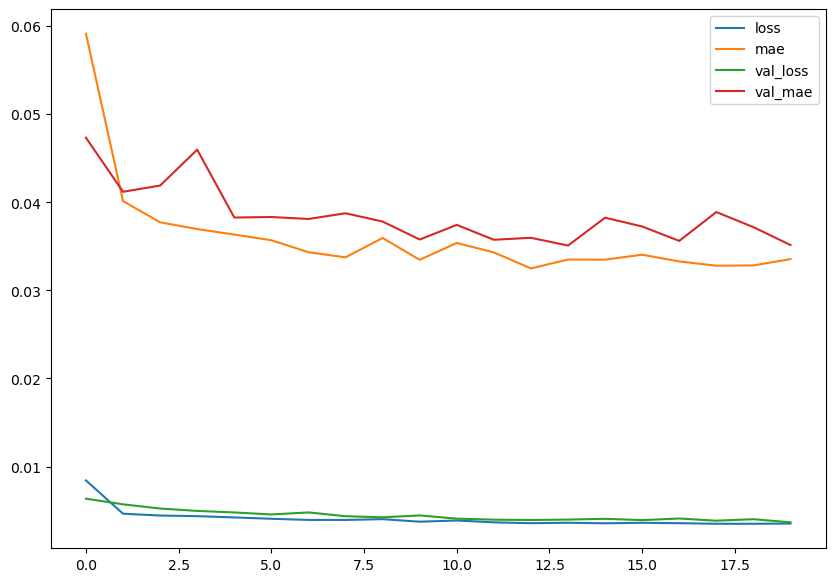

In [53]:
pd.DataFrame(history.history).plot(figsize=(10,7))

In [55]:
model.evaluate(x_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0033 - mae: 0.0345


[0.0036707555409520864, 0.03514980524778366]

In [57]:
predictions = model.predict(x_test)
predictions.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


(240, 1)

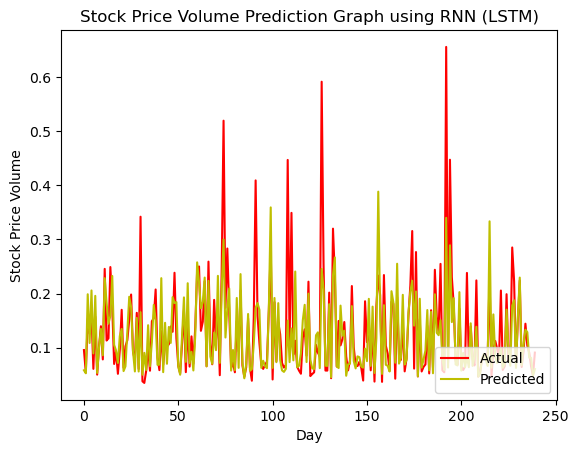

<Figure size 1000x700 with 0 Axes>

In [59]:
plt.plot(y_test, c = 'r')
plt.plot(predictions, c = 'y')
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title('Stock Price Volume Prediction Graph using RNN (LSTM)')
plt.legend(['Actual','Predicted'], loc = 'lower right')
plt.figure(figsize=(10,7))
plt.show()